In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Inspect single training

In [45]:
# train_folder = Path(
#     r"C:\Users\inserm\Documents\histo_sign\trainings\2024-03-12_15-30-06"
# )  # 4 signatures ppaint
train_folder = Path(
    r"C:\Users\inserm\Documents\histo_sign\trainings\signatures\2024-03-12_15-41-54"
)  # All signatures
# train_folder = Path(r"C:\Users\inserm\Documents\histo_sign\trainings\2024-03-12_15-50-27")  # Selec signatures
# train_folder = Path(r"C:\Users\inserm\Documents\histo_sign\trainings\2024-03-12_15-54-02")  # Classic Basal
# train_folder = Path(r"C:\Users\inserm\Documents\histo_sign\trainings\2024-03-12_15-56-31")  # Stroma Activ/Ina
# train_folder = Path(r"C:\Users\inserm\Documents\histo_sign\trainings\2024-03-12_16-01-52")  # Hwang only

In [46]:
# Open the txt file a dictionnary
with open(train_folder / "params.txt", "r") as file:
    params = file.readlines()
    params = eval(params[0])
params

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\inserm\\Documents\\histo_sign\\trainings\\signatures\\2024-03-12_15-41-54\\params.txt'

In [44]:
corr_df = pd.DataFrame()
for split in train_folder.glob("split_*"):
    split = split.name
    with open(train_folder / split / "val_corrs.npy", "rb") as file:
        corrs = np.load(file, allow_pickle=True)
        corrs = corrs.tolist()
        corrs = pd.DataFrame(corrs, index=[0])
        corrs["split"] = split
        corr_df = pd.concat([corr_df, corrs], axis=0)

corr_df.index = corr_df["split"]
corr_df = corr_df.drop(columns="split")
corr_df

KeyError: 'split'

<Axes: ylabel='split'>

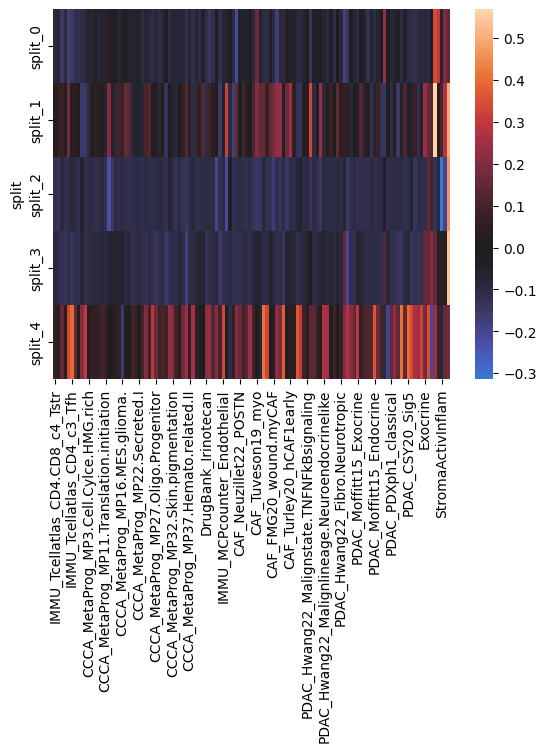

In [5]:
# Plot as a heatmap
sns.heatmap(corr_df, center=0)

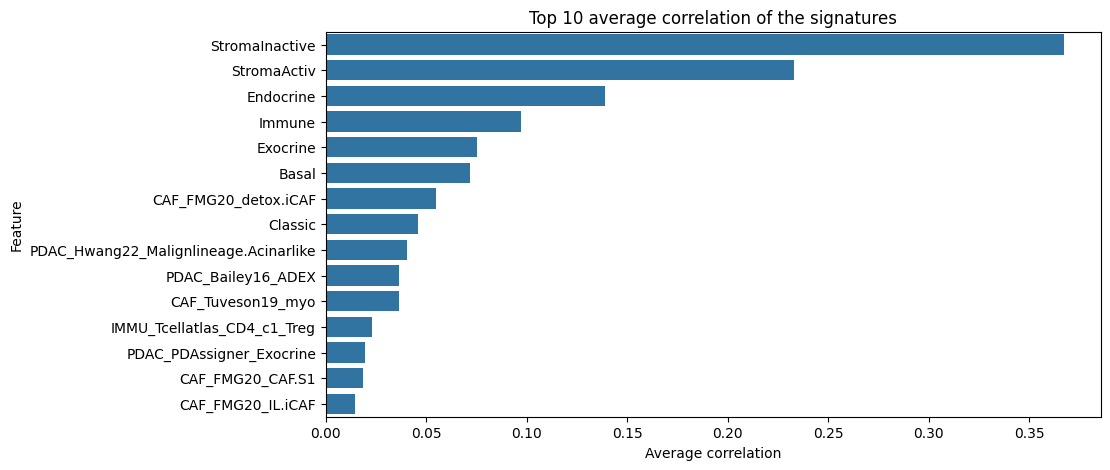

In [6]:
avg_corr = corr_df.mean(axis=0)
avg_corr = avg_corr.sort_values(ascending=False)

nb_top = 15

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=avg_corr[:nb_top], y=avg_corr.index[:nb_top], ax=ax)
ax.set_title("Average correlation of the top 10 signatures")
ax.set_title("Top 10 average correlation of the signatures")
ax.set_xlabel("Average correlation")
ax.set_ylabel("Feature")
plt.show()

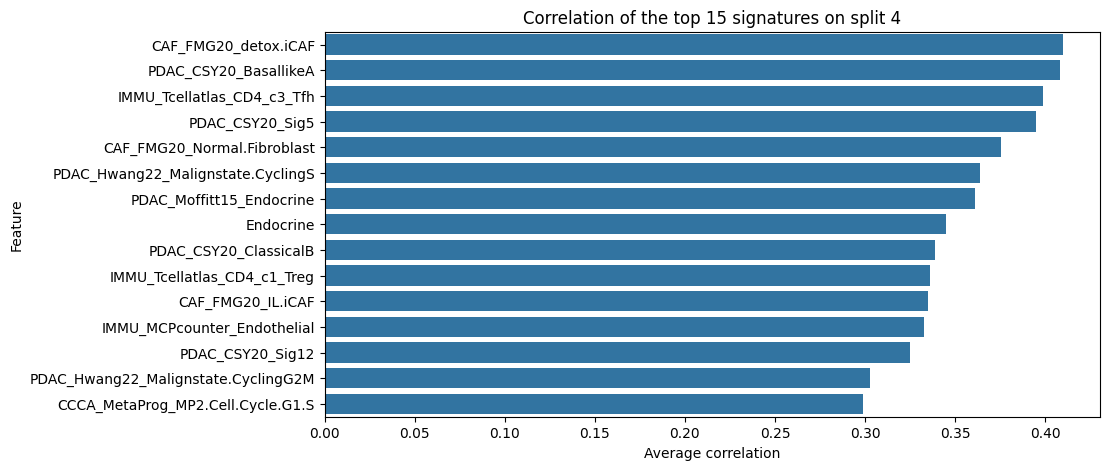

In [7]:
split_nb = 4
split_df = corr_df.loc[f"split_{split_nb}"]
split_df = split_df.sort_values(ascending=False)

nb_top = 15

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=split_df[:nb_top], y=split_df.index[:nb_top], ax=ax)
ax.set_title(f"Correlation of the top {nb_top} signatures on split {split_nb}")
ax.set_xlabel("Average correlation")
ax.set_ylabel("Feature")
plt.show()

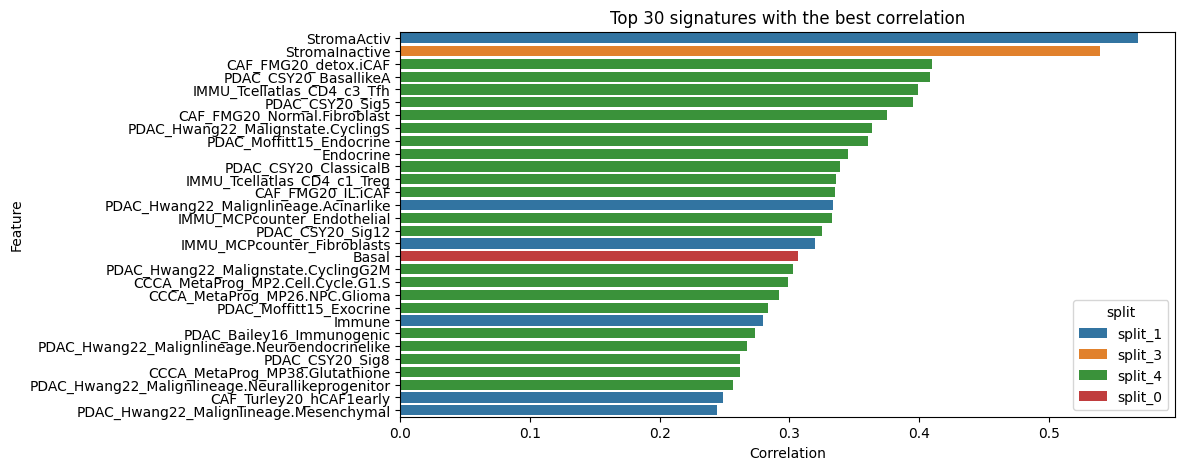

In [8]:
# Find the best split
best_split = corr_df.idxmax(axis=0).T
best_split = best_split.reset_index()
best_split.rename(columns={"index": "signature", 0: "split"}, inplace=True)
best_split["correlation"] = corr_df.max(axis=0).values
best_split.sort_values(by="correlation", ascending=False, inplace=True)
best_split.reset_index(drop=True, inplace=True)

n_top = 30
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(
    x=best_split["correlation"][:n_top],
    y=best_split["signature"][:n_top],
    ax=ax,
    hue=best_split["split"][:n_top],
)
ax.set_title(f"Top {n_top} signatures with the best correlation")
ax.set_xlabel("Correlation")
ax.set_ylabel("Feature")
plt.show()

In [9]:
best_split.to_csv(r"C:\Users\inserm\Documents\histo_sign\dataset\best_split.csv", index=False)

In [10]:
# new_col_to_pred = list(best_split[:n_top].signature.values)
# # new_col_to_pred = []
# new_col_to_pred += list(corr_df.filter(like="Hwang").columns.values)
# new_col_to_pred += ["Classic", "StromaActiv", "Basal", "StromaInactive"]
# new_col_to_pred = list(set(new_col_to_pred))
# np.savetxt(
#     Path(r"C:\Users\inserm\Documents\histo_sign\dataset\new_col_names.txt"),
#     new_col_to_pred,
#     fmt="%s",
#     encoding="utf-8",
# )

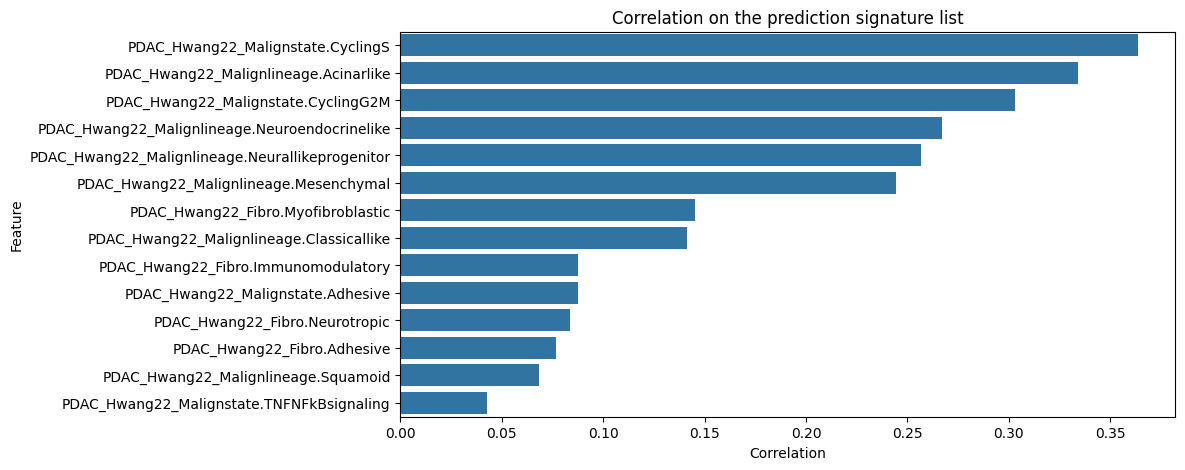

In [11]:
new_col_to_pred = np.loadtxt(
    Path(r"C:\Users\inserm\Documents\histo_sign\dataset\new_col_names.txt"),
    dtype=str,
    encoding="utf-8",
)
new_pred = best_split[best_split.signature.isin(new_col_to_pred)]
# plot
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=new_pred["correlation"], y=new_pred["signature"], ax=ax)
ax.set_title("Correlation on the prediction signature list")
ax.set_xlabel("Correlation")
ax.set_ylabel("Feature")
plt.show()

# All signatures training

In [2]:
# folder_path = Path(r"C:\Users\inserm\Documents\histo_sign\trainings\single_signatures\2024-03-15_15-44-10") # selected signatures
folder_path = Path(
    r"C:\Users\inserm\Documents\histo_sign\trainings\single_signatures\2024-03-15_16-00-21"
)  # all signatures

In [3]:
sign_path = list(folder_path.glob("*"))
sign_path = [x for x in sign_path if x.is_dir()]
sign_name = [x.name for x in sign_path]
recap_df = pd.DataFrame({"signature": sign_name, "path": sign_path})

In [4]:
def get_sgn(row):
    corr_sgn = {}
    for k in range(0, 5):
        val_corr = np.load(row.path / f"split_{k}" / "val_corrs.npy", allow_pickle=True)
        val_corr = val_corr.tolist()
        # print(val_corr.keys())
        if row.signature in val_corr:
            val_corr = val_corr[row.signature]
        elif row.signature == "CCCA_MetaProg_MP16.MES.glioma":
            val_corr = val_corr["CCCA_MetaProg_MP16.MES.glioma."]
        elif row.signature == "CCCA_MetaProg_MP17.Interferon.MHC.II.I":
            val_corr = val_corr["CCCA_MetaProg_MP17.Interferon.MHC.II.I."]
        elif row.signature == "CCCA_MetaProg_MP18.Interferon.MHC.II.II":
            val_corr = val_corr["CCCA_MetaProg_MP18.Interferon.MHC.II.II."]
        elif row.signature == "CCCA_MetaProg_MP7.Stress.in.vitro":
            val_corr = val_corr["CCCA_MetaProg_MP7.Stress.in.vitro."]
        else:
            raise ValueError(f"{row.signature} not found in {val_corr.keys()}")
        corr_sgn[f"split_{k}"] = val_corr
    return corr_sgn


res = recap_df.apply(get_sgn, axis=1, result_type="expand")
recap_df = pd.concat([recap_df, res], axis=1)

In [5]:
recap_df["mean_corr"] = recap_df.filter(like="split_").mean(axis=1)
recap_df["best_split"] = recap_df.filter(like="split_").idxmax(axis=1)
recap_df["best_corr"] = recap_df.filter(like="split_").max(axis=1)
recap_df["model_path"] = recap_df.apply(lambda x: x.path / x.best_split / "model.pth", axis=1)
recap_df.sort_values(by="best_corr", ascending=False, inplace=True)
recap_df.reset_index(drop=True, inplace=True)

In [6]:
selected_sign = np.loadtxt(
    r"C:\Users\inserm\Documents\histo_sign\dataset\selected_col_names.txt", dtype=str, encoding="utf-8"
)
recap_df["selected"] = recap_df.signature.isin(selected_sign)

In [7]:
recap_df

,signature,path,split_0,split_1,split_2,split_3,split_4,mean_corr,best_split,best_corr,model_path,selected
0,IMMU_MCPcounter_B.lineage,C:\Users\inserm\Documents\histo_sign\trainings...,0.746075,0.720110,-0.062031,-0.064562,0.819710,0.431860,split_4,0.819710,C:\Users\inserm\Documents\histo_sign\trainings...,False
1,IMMU_Tcellatlas_CD4_Tn,C:\Users\inserm\Documents\histo_sign\trainings...,-0.004590,0.781967,0.378163,-0.123152,0.028793,0.212236,split_1,0.781967,C:\Users\inserm\Documents\histo_sign\trainings...,False
2,IMMU_Tcellatlas_CD8_Tn,C:\Users\inserm\Documents\histo_sign\trainings...,0.131530,0.754582,0.779469,0.182573,0.074314,0.384494,split_2,0.779469,C:\Users\inserm\Documents\histo_sign\trainings...,False
3,PDAC_Moffitt15_Exocrine,C:\Users\inserm\Documents\histo_sign\trainings...,0.014738,-0.044066,0.753564,0.406195,-0.065519,0.212982,split_2,0.753564,C:\Users\inserm\Documents\histo_sign\trainings...,False
4,PDAC_Bailey16_ADEX,C:\Users\inserm\Documents\histo_sign\trainings...,-0.052856,0.157869,0.744642,0.215211,0.139089,0.240791,split_2,0.744642,C:\Users\inserm\Documents\histo_sign\trainings...,False
...,...,...,...,...,...,...,...,...,...,...,...,...
113,IMMU_MCPcounter_Endothelial,C:\Users\inserm\Documents\histo_sign\trainings...,-0.017318,-0.122113,-0.059977,-0.031679,-0.102089,-0.066635,split_0,-0.017318,C:\Users\inserm\Documents\histo_sign\trainings...,False
114,CCCA_MetaProg_MP26.NPC.Glioma,C:\Users\inserm\Documents\histo_sign\trainings...,-0.032799,-0.138786,-0.032021,-0.019266,-0.026801,-0.049935,split_3,-0.019266,C:\Users\inserm\Documents\histo_sign\trainings...,False
115,DrugBank_Irinotecan,C:\Users\inserm\Documents\histo_sign\trainings...,-0.082593,-0.103096,-0.065664,-0.066877,-0.171692,-0.097984,split_2,-0.065664,C:\Users\inserm\Documents\histo_sign\trainings...,False
116,CCCA_MetaProg_MP23.Secreted.II,C:\Users\inserm\Documents\histo_sign\trainings...,-0.118967,-0.158795,-0.087828,-0.096360,-0.130070,-0.118404,split_2,-0.087828,C:\Users\inserm\Documents\histo_sign\trainings...,False


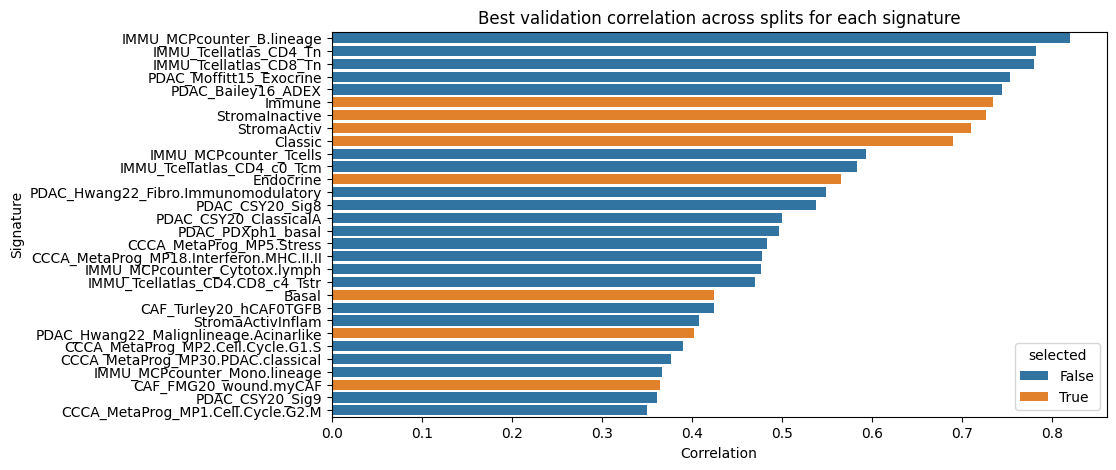

In [8]:
# plot
n_top = 30
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(
    x=recap_df["best_corr"][:n_top], y=recap_df["signature"][:n_top], ax=ax, hue=recap_df["selected"][:n_top]
)
ax.set_title("Best validation correlation across splits for each signature")
ax.set_xlabel("Correlation")
ax.set_ylabel("Signature")
plt.show()

Keeping 11 models


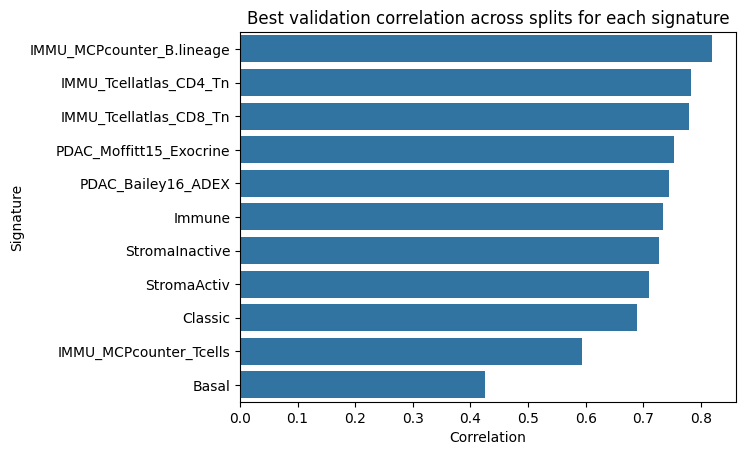

In [9]:
valid_model = recap_df[:10]
valid_sign = valid_model.signature.values
valid_sign = list(set(valid_sign).union(set(["Classic", "StromaActiv", "Basal", "StromaInactive"])))
valid_model = recap_df[recap_df.signature.isin(valid_sign)]

res = valid_model[["signature", "model_path"]]
res_dict = res.set_index("signature").T.to_dict("list")
for k, v in res_dict.items():
    res_dict[k] = v[0].as_posix()
print(f"Keeping {len(res_dict)} models")
# np.save(r"C:\Users\inserm\Documents\histo_sign\dataset\best_model_path.npy", res_dict)
sns.barplot(data=valid_model, x="best_corr", y="signature")
plt.title("Best validation correlation across splits for each signature")
plt.xlabel("Correlation")
plt.ylabel("Signature")
plt.show()

In [64]:
recap_df[recap_df.signature.str.contains("Basal")]
recap_df[recap_df.signature.str.contains("Classic")]
recap_df[recap_df.signature.str.contains("Stroma")]

,signature,path,split_0,split_1,split_2,split_3,split_4,split_0,split_1,split_2,split_3,split_4,mean_corr,best_split,best_corr,model_path,selected
6,StromaInactive,C:\Users\inserm\Documents\histo_sign\trainings...,0.399919,0.727137,0.690838,0.560017,0.638029,0.399919,0.727137,0.690838,0.560017,0.638029,0.603188,split_1,0.727137,C:\Users\inserm\Documents\histo_sign\trainings...,True
7,StromaActiv,C:\Users\inserm\Documents\histo_sign\trainings...,0.709637,0.327678,0.654846,0.606874,0.661443,0.709637,0.327678,0.654846,0.606874,0.661443,0.592095,split_0,0.709637,C:\Users\inserm\Documents\histo_sign\trainings...,True
22,StromaActivInflam,C:\Users\inserm\Documents\histo_sign\trainings...,0.201160,0.245549,0.144081,0.267694,0.407920,0.201160,0.245549,0.144081,0.267694,0.407920,0.253280,split_4,0.407920,C:\Users\inserm\Documents\histo_sign\trainings...,False
50,PDAC_Moffitt15_ActivatedStroma,C:\Users\inserm\Documents\histo_sign\trainings...,-0.054091,0.179484,0.224840,-0.010891,-0.087290,-0.054091,0.179484,0.224840,-0.010891,-0.087290,0.050410,split_2,0.224840,C:\Users\inserm\Documents\histo_sign\trainings...,False
69,PDAC_Moffitt15_NormalStroma,C:\Users\inserm\Documents\histo_sign\trainings...,0.001179,-0.114599,0.073124,0.156577,0.019387,0.001179,-0.114599,0.073124,0.156577,0.019387,0.027133,split_3,0.156577,C:\Users\inserm\Documents\histo_sign\trainings...,False


Keeping 9 models


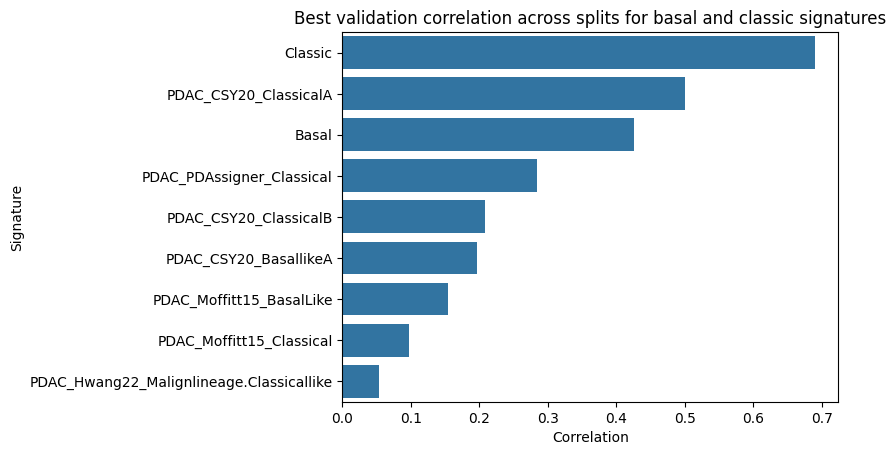

In [74]:
classic_basal_sign = recap_df[
    recap_df.signature.str.contains("Basal") | recap_df.signature.str.contains("Classic")
]
classic_basal_sign = classic_basal_sign.signature.values
classic_basal_sign = list(set(classic_basal_sign).union(set(["Classic", "Basal"])))
classic_basal_sign = recap_df[recap_df.signature.isin(classic_basal_sign)]

res = classic_basal_sign[["signature", "model_path"]]
res_dict = res.set_index("signature").T.to_dict("list")
for k, v in res_dict.items():
    res_dict[k] = v[0].as_posix()
print(f"Keeping {len(res_dict)} models")
# np.save(r"C:\Users\inserm\Documents\histo_sign\dataset\classic_basal_model_path.npy", res_dict)

sns.barplot(data=classic_basal_sign, x="best_corr", y="signature")
plt.title("Best validation correlation across splits for basal and classic signatures")
plt.xlabel("Correlation")
plt.ylabel("Signature")
plt.show()

Keeping 18 models


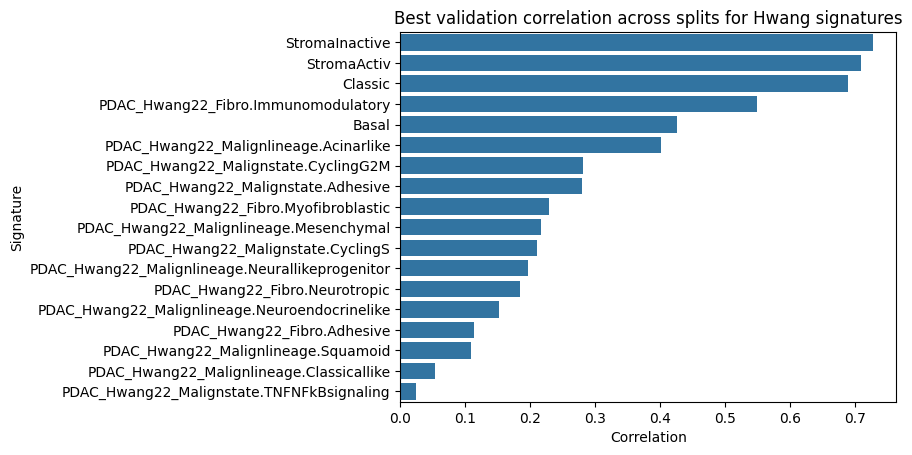

In [75]:
hwang_df = recap_df[recap_df.signature.str.contains("Hwang")]
hwang_sign = hwang_df.signature.values
hwang_sign = list(set(hwang_sign).union(set(["Classic", "StromaActiv", "Basal", "StromaInactive"])))
hwang_df = recap_df[recap_df.signature.isin(hwang_sign)]

res = hwang_df[["signature", "model_path"]]
res_dict = res.set_index("signature").T.to_dict("list")
for k, v in res_dict.items():
    res_dict[k] = v[0].as_posix()

print(f"Keeping {len(res_dict)} models")
# np.save(r"C:\Users\inserm\Documents\histo_sign\dataset\hwang_model_path.npy", res_dict)
sns.barplot(data=hwang_df, x="best_corr", y="signature")
plt.title("Best validation correlation across splits for Hwang signatures")
plt.xlabel("Correlation")
plt.ylabel("Signature")
plt.show()

Keeping 118 models


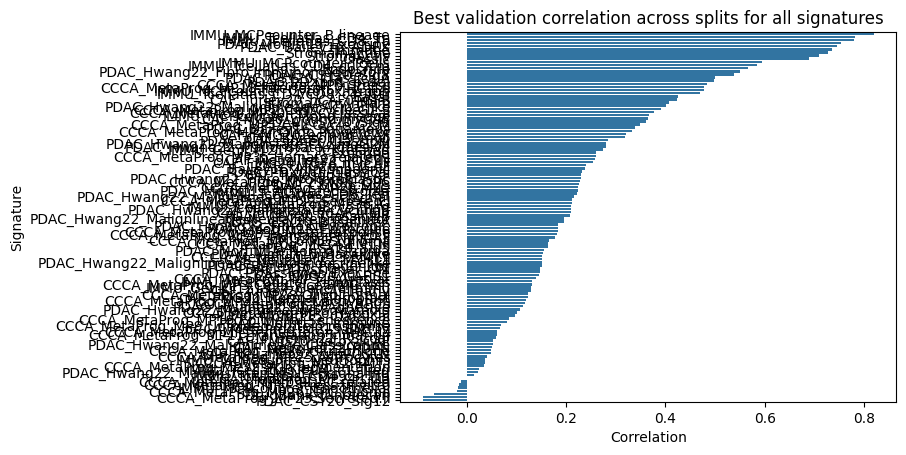

In [76]:
all_sign = recap_df.signature.values
all_sign = list(set(all_sign).union(set(["Classic", "StromaActiv", "Basal", "StromaInactive"])))
all_sign = recap_df[recap_df.signature.isin(all_sign)]

res = all_sign[["signature", "model_path"]]
res_dict = res.set_index("signature").T.to_dict("list")
for k, v in res_dict.items():
    res_dict[k] = v[0].as_posix()
print(f"Keeping {len(res_dict)} models")
# np.save(r"C:\Users\inserm\Documents\histo_sign\dataset\all_model_path.npy", res_dict)
sns.barplot(data=all_sign, x="best_corr", y="signature")
plt.title("Best validation correlation across splits for all signatures")
plt.xlabel("Correlation")
plt.ylabel("Signature")
plt.show()